<a href="https://colab.research.google.com/github/Sidqinabhan/Robotika/blob/main/Week%2013.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

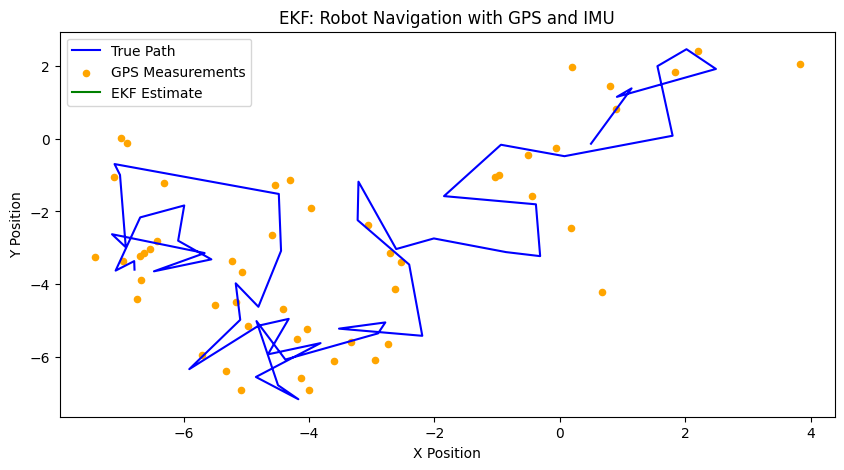

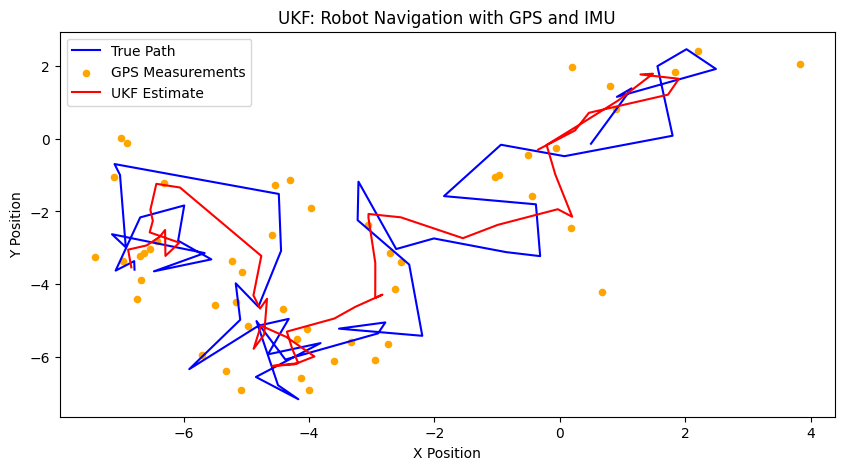

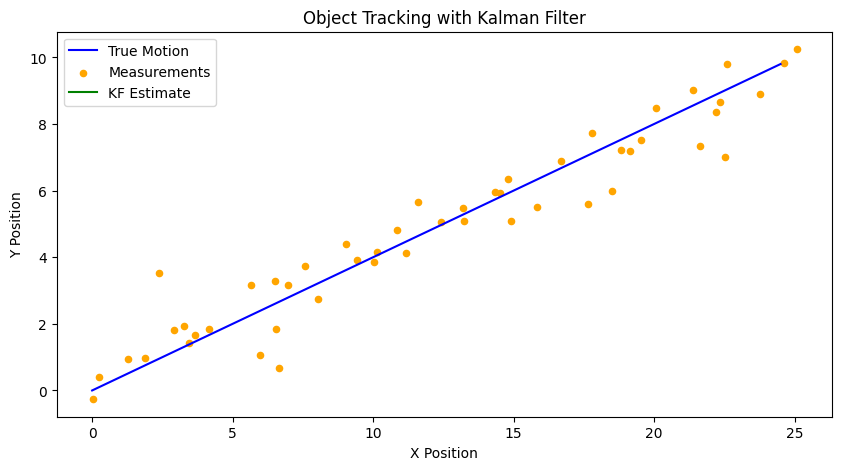

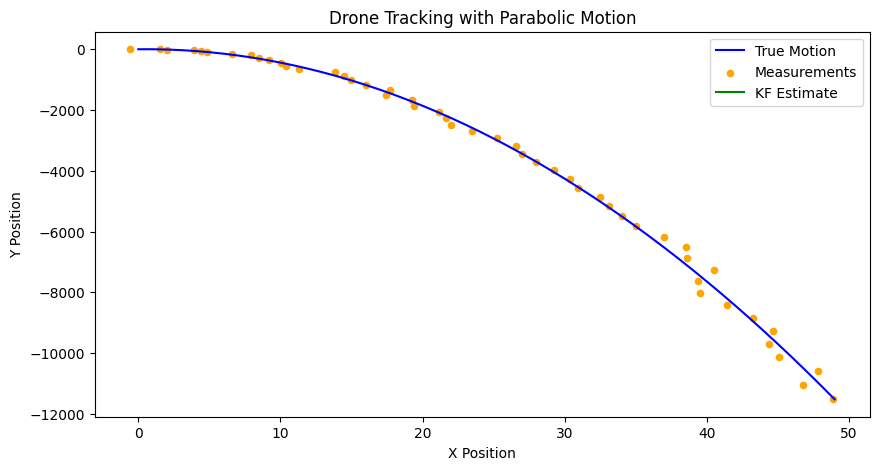

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import block_diag

# --- Extended Kalman Filter (EKF): Robot Navigation with GPS and IMU ---
class EKF:
    def __init__(self, state_dim, meas_dim, process_noise, meas_noise):
        self.x = np.zeros(state_dim)  # State vector
        self.P = np.eye(state_dim)    # State covariance matrix
        self.Q = process_noise        # Process noise covariance
        self.R = meas_noise           # Measurement noise covariance
        self.F = np.eye(state_dim)    # State transition model
        self.H = np.zeros((meas_dim, state_dim))  # Measurement model

    def predict(self, u):
        self.x = self.F @ self.x + u
        self.P = self.F @ self.P @ self.F.T + self.Q

    def update(self, z):
        y = z - self.H @ self.x
        S = self.H @ self.P @ self.H.T + self.R
        K = self.P @ self.H.T @ np.linalg.inv(S)
        self.x += K @ y
        self.P = (np.eye(len(self.x)) - K @ self.H) @ self.P

# Simulate EKF with GPS and IMU
np.random.seed(42)
t_steps = 50
actual_path = np.cumsum(np.random.randn(t_steps, 2), axis=0)
gps_noise = np.diag([0.5, 0.5])
gps_measurements = actual_path + np.random.multivariate_normal([0, 0], gps_noise, t_steps)

ekf = EKF(4, 2, np.diag([0.1, 0.1, 0.1, 0.1]), gps_noise)
positions = []
for z in gps_measurements:
    ekf.predict(u=np.zeros(4))
    ekf.update(z=z)
    positions.append(ekf.x[:2])
positions = np.array(positions)

plt.figure(figsize=(10, 5))
plt.plot(actual_path[:, 0], actual_path[:, 1], label="True Path", c="blue")
plt.scatter(gps_measurements[:, 0], gps_measurements[:, 1], label="GPS Measurements", c="orange", s=20)
plt.plot(positions[:, 0], positions[:, 1], label="EKF Estimate", c="green")
plt.legend()
plt.xlabel("X Position")
plt.ylabel("Y Position")
plt.title("EKF: Robot Navigation with GPS and IMU")
plt.show()

# --- Unscented Kalman Filter (UKF): Robot Navigation with GPS and IMU ---
def unscented_transform(sigma_points, weights):
    mean = np.sum(weights[:, None] * sigma_points, axis=0)
    cov = np.sum([weights[i] * np.outer(sigma_points[i] - mean, sigma_points[i] - mean) for i in range(len(weights))], axis=0)
    return mean, cov

class UKF:
    def __init__(self, state_dim, meas_dim, process_noise, meas_noise):
        self.x = np.zeros(state_dim)  # State vector
        self.P = np.eye(state_dim)    # State covariance matrix
        self.Q = process_noise        # Process noise covariance
        self.R = meas_noise           # Measurement noise covariance
        self.n = state_dim
        self.alpha = 0.001
        self.beta = 2
        self.kappa = 0  # Set to 0 to avoid negative weights
        self.lambda_ = self.alpha**2 * (self.n + self.kappa) - self.n
        self.gamma = np.sqrt(self.n + self.lambda_)

    def sigma_points(self):
        sigma = np.zeros((2 * self.n + 1, self.n))
        sqrt_P = np.linalg.cholesky((self.n + self.lambda_) * self.P)
        sigma[0] = self.x
        for i in range(self.n):
            sigma[i + 1] = self.x + sqrt_P[i]
            sigma[self.n + i + 1] = self.x - sqrt_P[i]
        return sigma

    def predict(self, process_model):
        sigma_points = self.sigma_points()
        sigma_predict = np.array([process_model(sigma) for sigma in sigma_points])
        weights = np.zeros(2 * self.n + 1)
        weights[0] = self.lambda_ / (self.n + self.lambda_)
        weights[1:] = 0.5 / (self.n + self.lambda_)
        self.x, self.P = unscented_transform(sigma_predict, weights)
        self.P += self.Q

    def update(self, z, measurement_model):
        sigma_points = self.sigma_points()
        sigma_measurements = np.array([measurement_model(sigma) for sigma in sigma_points])
        weights = np.zeros(2 * self.n + 1)
        weights[0] = self.lambda_ / (self.n + self.lambda_)
        weights[1:] = 0.5 / (self.n + self.lambda_)
        z_pred, S = unscented_transform(sigma_measurements, weights)
        S += self.R
        cross_cov = np.sum([weights[i] * np.outer(sigma_points[i] - self.x, sigma_measurements[i] - z_pred) for i in range(2 * self.n + 1)], axis=0)
        K = cross_cov @ np.linalg.inv(S)
        self.x += K @ (z - z_pred)
        self.P -= K @ S @ K.T

# Simulate UKF with GPS and IMU
def process_model(state):
    return state  # Placeholder for actual process model

def measurement_model(state):
    return state[:2]  # Placeholder for measurement model

ukf = UKF(4, 2, np.diag([0.1, 0.1, 0.1, 0.1]), gps_noise)
ukf_positions = []
for z in gps_measurements:
    ukf.predict(process_model)
    ukf.update(z, measurement_model)
    ukf_positions.append(ukf.x[:2])
ukf_positions = np.array(ukf_positions)

plt.figure(figsize=(10, 5))
plt.plot(actual_path[:, 0], actual_path[:, 1], label="True Path", c="blue")
plt.scatter(gps_measurements[:, 0], gps_measurements[:, 1], label="GPS Measurements", c="orange", s=20)
plt.plot(ukf_positions[:, 0], ukf_positions[:, 1], label="UKF Estimate", c="red")
plt.legend()
plt.xlabel("X Position")
plt.ylabel("Y Position")
plt.title("UKF: Robot Navigation with GPS and IMU")
plt.show()

# --- Tracking Object with Kalman Filter ---
def simulate_object_motion(t_steps, init_pos, velocity):
    motion = [init_pos + i * velocity for i in range(t_steps)]
    return np.array(motion)

object_motion = simulate_object_motion(t_steps, np.array([0, 0]), np.array([0.5, 0.2]))
object_measurements = object_motion + np.random.multivariate_normal([0, 0], gps_noise, t_steps)

kf_positions = []
kalman_filter = EKF(4, 2, np.diag([0.1, 0.1, 0.1, 0.1]), gps_noise)
for z in object_measurements:
    kalman_filter.predict(u=np.zeros(4))
    kalman_filter.update(z=z)
    kf_positions.append(kalman_filter.x[:2])
kf_positions = np.array(kf_positions)

plt.figure(figsize=(10, 5))
plt.plot(object_motion[:, 0], object_motion[:, 1], label="True Motion", c="blue")
plt.scatter(object_measurements[:, 0], object_measurements[:, 1], label="Measurements", c="orange", s=20)
plt.plot(kf_positions[:, 0], kf_positions[:, 1], label="KF Estimate", c="green")
plt.legend()
plt.xlabel("X Position")
plt.ylabel("Y Position")
plt.title("Object Tracking with Kalman Filter")
plt.show()

# --- Tracking Drone with Parabolic Motion ---
def simulate_drone_motion(t_steps, init_pos, init_velocity, gravity):
    motion = [init_pos + np.array([v * i, init_velocity[1] * i - 0.5 * gravity * i**2]) for i, v in enumerate([init_velocity[0]] * t_steps)]
    return np.array(motion)

drone_motion = simulate_drone_motion(t_steps, np.array([0, 0]), np.array([1, 5]), gravity=9.8)
drone_measurements = drone_motion + np.random.multivariate_normal([0, 0], gps_noise, t_steps)

dr_positions = []
dr_kf = EKF(4, 2, np.diag([0.1, 0.1, 0.1, 0.1]), gps_noise)
for z in drone_measurements:
    dr_kf.predict(u=np.zeros(4))
    dr_kf.update(z=z)
    dr_positions.append(dr_kf.x[:2])
dr_positions = np.array(dr_positions)

plt.figure(figsize=(10, 5))
plt.plot(drone_motion[:, 0], drone_motion[:, 1], label="True Motion", c="blue")
plt.scatter(drone_measurements[:, 0], drone_measurements[:, 1], label="Measurements", c="orange", s=20)
plt.plot(dr_positions[:, 0], dr_positions[:, 1], label="KF Estimate", c="green")
plt.legend()
plt.xlabel("X Position")
plt.ylabel("Y Position")
plt.title("Drone Tracking with Parabolic Motion")
plt.show()
